In [ ]:
from properties import POSTGRES_CREDENTIALS
from utils import create_connection
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import upsetplot
import itertools
import numpy as np

In [6]:
conn, cursor = create_connection("genius_db")
cursor.execute("select song_id, cluster_id from song_cluster")
song_cluster = pd.DataFrame(cursor.fetchall(), columns =["song_id", "cluster_id"])
cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'cluster'")
columns = list(map(lambda x: x[0], cursor.fetchall()))
cursor.execute("select * from cluster")
cluster = pd.DataFrame(cursor.fetchall(), columns=columns).set_index("cluster_id")
conn.close()

In [7]:
conn, cursor = create_connection("lfm2b")

# Create a forwarder to the genius DB so that we can easily join tables.
# assert False, "Warning! This can take multiple hours if this is the first time running"
script = f"""
CREATE EXTENSION IF NOT EXISTS postgres_fdw;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM pg_foreign_server WHERE srvname = 'genius_server'
  ) THEN
    CREATE SERVER genius_server
      FOREIGN DATA WRAPPER postgres_fdw
      OPTIONS (host '{POSTGRES_CREDENTIALS["host"]}', dbname 'genius_db', port '{POSTGRES_CREDENTIALS["port"]}');
  END IF;
END
$$;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM pg_user_mappings
    WHERE srvname = 'genius_server'
    AND umuser = (SELECT usesysid FROM pg_user WHERE usename = 'postgres')
  ) THEN
    CREATE USER MAPPING FOR postgres
      SERVER genius_server
      OPTIONS (user '{POSTGRES_CREDENTIALS["user"]}', password '{POSTGRES_CREDENTIALS["password"]}');
  END IF;
END
$$;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM information_schema.tables
    WHERE table_schema = 'public' AND table_name = 'lfm2b_genius'
  ) THEN
    IMPORT FOREIGN SCHEMA public
      LIMIT TO (lfm2b_genius)
      FROM SERVER genius_server
      INTO public;
  END IF;
END
$$;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM information_schema.tables
    WHERE table_schema = 'public' AND table_name = 'song_cluster'
  ) THEN
    IMPORT FOREIGN SCHEMA public
      LIMIT TO (song_cluster)
      FROM SERVER genius_server
      INTO public;
  END IF;
END
$$;
"""


cursor.execute(script)
cursor.execute("""
CREATE TABLE IF NOT EXISTS le_joined_tni AS
SELECT * FROM listening_event WHERE false; -- Empty table with correct schema

DO $$
DECLARE
  chunk_size INTEGER := 10000000;
  max_id INTEGER := 50813339; 
  start_id INTEGER := 0;
BEGIN
  IF NOT EXISTS (SELECT 1 FROM le_joined_tni) THEN
    WHILE start_id < max_id LOOP
      RAISE NOTICE 'Processing track_id % to %', start_id, start_id + chunk_size - 1;

      INSERT INTO le_joined_tni
      SELECT le.*
      FROM listening_event le
      JOIN track_non_instrumental tni
        ON le.track_id = tni.track_id
      WHERE le.track_id >= start_id AND le.track_id < start_id + chunk_size;

      start_id := start_id + chunk_size;
    END LOOP;
  END IF;
END
$$ LANGUAGE plpgsql;

CREATE INDEX IF NOT EXISTS le_ni_track_id_idx ON le_joined_tni(track_id);
CREATE INDEX IF NOT EXISTS le_ni_age_at_listen_idx ON le_joined_tni(age_at_listen);
""")

conn.commit()
print("Running")
cursor.execute("select lg.song_id, le.user_id, le.track_id, le.age_at_listen, le.artist_id from listening_event le join lfm2b_genius lg using(track_id)")
le_data = pd.DataFrame(cursor.fetchall(), columns=["song_id", "user_id", "track_id", "age_at_listen", "artist_id"])
conn.close()

Running


In [8]:
listening_events_with_clusters = le_data.merge(song_cluster, on="song_id")

In [9]:
conn, cursor = create_connection("lfm2b")
cursor.execute("select age_at_listen, count(track_id) from le_joined_tni group by age_at_listen;")
non_instrumental = pd.DataFrame(cursor.fetchall(), columns=["age_at_listen", "amt_le"]).set_index("age_at_listen")

cursor.execute("select age_at_listen, count(track_id) from listening_event join lfm2b_genius using(track_id) group by age_at_listen")
matches = pd.DataFrame(cursor.fetchall(), columns=["age_at_listen", "amt_le"]).set_index("age_at_listen")
conn.close()


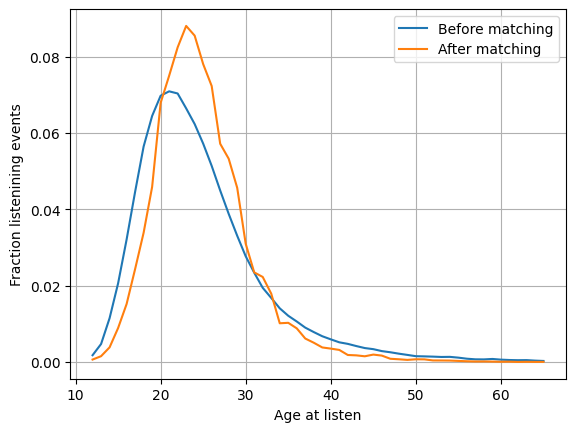

Thrown away 99.87%
Remained 0.13%


In [10]:

merged = non_instrumental.join(matches, lsuffix="_instrumental", rsuffix="_matched")
merged.div(merged.sum(axis=0), axis=1).rename(
    columns={
        "amt_le_instrumental": "Before matching",
        "amt_le_matched": "After matching",
    }
).plot.line(
    # title="Distribution of listening events over ages",
    xlabel="Age at listen",
    ylabel="Fraction listenining events",
)
plt.grid()
plt.show()

totals = merged.sum(axis=0)

a = totals["amt_le_instrumental"]
b = totals["amt_le_matched"]

print(f"Thrown away {abs((b-a)/a):.2%}")
print(f"Remained {b/a:.2%}")

In [11]:
# Let's create a pivot table to see the amount of listening events per age_group and cluster
# https://www.statology.org/pandas-pivot-table-count/
pt = (
    pd.pivot_table(
        listening_events_with_clusters,
        values="track_id",
        index="age_at_listen",
        columns="cluster_id",
        aggfunc="count",
    )
    .fillna(0)
    .astype(int)
)

songs_per_cluster = song_cluster.groupby("cluster_id").count().reset_index()

print(
    pt.to_latex(
        escape=True,
        caption="LE count per cluster per age",
        label="table:le_count_cluster_age"
    )
)

\begin{table}
\caption{LE count per cluster per age}
\label{table:le_count_cluster_age}
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
cluster_id & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19 \\
age_at_listen &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
12 & 170 & 11 & 20 & 22 & 2 & 80 & 1 & 13 & 1 & 47 & 92 & 27 & 108 & 80 & 13 & 0 & 64 & 5 & 116 & 0 \\
13 & 149 & 24 & 40 & 34 & 25 & 232 & 24 & 74 & 16 & 84 & 120 & 198 & 321 & 302 & 124 & 36 & 234 & 17 & 189 & 4 \\
14 & 423 & 20 & 116 & 44 & 93 & 646 & 26 & 199 & 14 & 137 & 300 & 494 & 925 & 812 & 287 & 94 & 555 & 77 & 233 & 5 \\
15 & 1080 & 162 & 296 & 219 & 412 & 1767 & 93 & 254 & 73 & 526 & 668 & 976 & 1665 & 2000 & 577 & 219 & 1362 & 99 & 675 & 5 \\
16 & 1561 & 236 & 984 & 292 & 449 & 3175 & 105 & 581 & 65 & 707 & 1063 & 2425 & 2817 & 2462 & 1024 & 511 & 2872 & 224 & 913 & 9 \\
17 & 3380 & 616 & 1445 & 663 & 850 & 3971 & 220 & 982 & 117 & 1929 & 1930 & 2595 & 

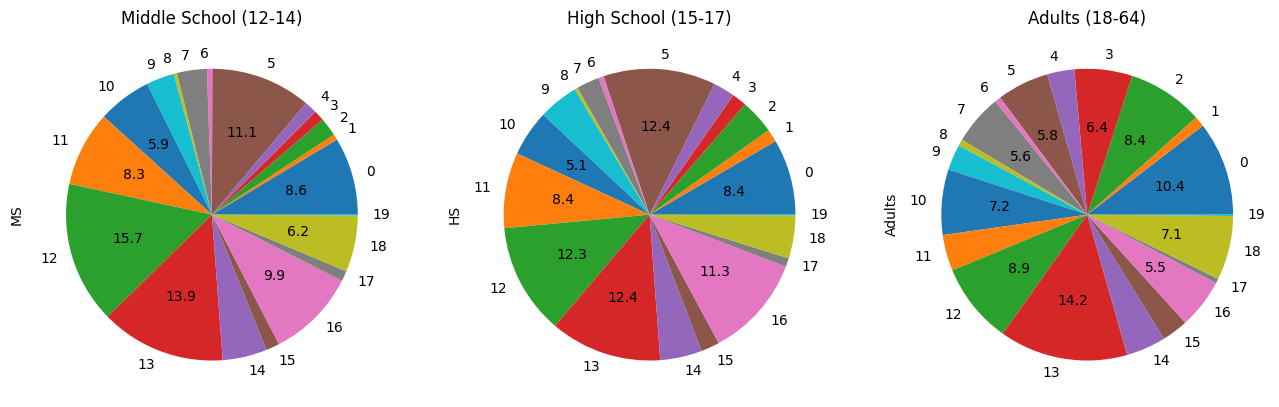

In [12]:
middle_school = pt.loc[12:14].sum()
middle_school.name = "MS"
high_school = pt.loc[15:17].sum()
high_school.name = "HS"
adults = pt.loc[18:].sum()
adults.name="Adults"
children = pt.loc[12:17].sum()
children.name="Children"


fig, (ax1, ax2, ax3) = plt.subplots(figsize = (16,9), ncols=3)

# https://stackoverflow.com/questions/63704956/pie-chart-show-percentage-of-specific-values#63705426 
show_percentages_more_than_5_perc = lambda val : ('%.1f' % val) if val > 5 else ''

middle_school.plot.pie(ax=ax1, title="Middle School (12-14)",autopct=show_percentages_more_than_5_perc)
high_school.plot.pie(ax=ax2, title="High School (15-17)", autopct=show_percentages_more_than_5_perc)
adults.plot.pie(ax=ax3, title="Adults (18-64)", autopct=show_percentages_more_than_5_perc)
plt.show()


le_counts_grouped = pd.concat([children, middle_school, high_school, adults], axis=1)

In [26]:
le_counts_grouped[["MS", "HS", "Adults"]]
by_structures = pd.DataFrame(columns=["MS", "HS", "Adults"])
by_structures.loc["Hooky"] = le_counts_grouped.loc[[5,11,16]].sum()
by_structures.loc["Chorusy"] = le_counts_grouped.loc[[2,3]].sum()
by_structures.loc["Flowy"] = le_counts_grouped.loc[12]
by_structures.loc["Other"] = le_counts_grouped.loc[[0,1,4,6,7,8,9,10,13,14,15,17,18,19]].sum()
by_structures

,MS,HS,Adults
Hooky,2530,23033,213016
Chorusy,276,3899,207057
Flowy,1354,8804,125101
Other,4459,35862,853228


In [ ]:
# Manual calculation for significane using Chi-square test 
observed = le_counts_grouped[["MS", "HS", "Adults"]]
observed["total"] = observed.sum(axis='columns')
observed.loc["total"] = observed.sum(axis='index')

# Calculate the expected values under the assumption that the distribution is equal among the three groups
age_group_fractions = observed.loc["total"][["MS", "HS", "Adults"]]/observed.loc["total"]["total"]
expected = pd.DataFrame(
    [
        age_group_fractions["MS"] * observed.loc[0:19]["total"],
        age_group_fractions["HS"] * observed.loc[0:19]["total"],
        age_group_fractions["Adults"] * observed.loc[0:19]["total"]
    ], index=["MS", "HS", "Adults"]
).T

# Calculate the Chi^2 value 
obs = observed.loc[0:19][["MS", "HS", "Adults"]] # Remove the totals
chi_sq_value = ((expected-obs)**2/expected).sum(axis='columns').sum(axis='index')
degrees_of_freedom=(len(obs.columns)-1) * (len(obs.index) -1)
chi_sq_value

# ------------------------------------------------------------------------------------------------------------------------
# Scipy calculation 

chi2, p, dof, exp = chi2_contingency(le_counts_grouped[["MS", "HS", "Adults"]])

assert chi_sq_value == chi2
assert degrees_of_freedom == dof
assert np.allclose(expected.to_numpy(), exp, atol=1e-10)
print("MS->HS->Adults")
print(f"\tChi-squared: {chi2}")
print(f"\tDegrees of freedom: {dof}")
print(f"\tp-value: {p}")
print(f"\tsignificant={p<0.05}")

assert p < 0.005, "Result not significant"

print()
# Lets inspect if we take each 2 group combination
for a, b in [("MS", "HS"), ("HS", "Adults"), ("MS", "Adults"), ("Children", "Adults")]:
    _, p, _, _ = chi2_contingency(le_counts_grouped[[a, b]])
    print(f"{a}->{b}: p={p}, significant={p<0.05}")

MS->HS->Adults
	Chi-squared: 23526.525159963207
	Degrees of freedom: 38
	p-value: 0.0
	significant=True

MS->HS: p=5.755530751990348e-66, significant=True
HS->Adults: p=0.0, significant=True
MS->Adults: p=0.0, significant=True
Children->Adults: p=0.0, significant=True


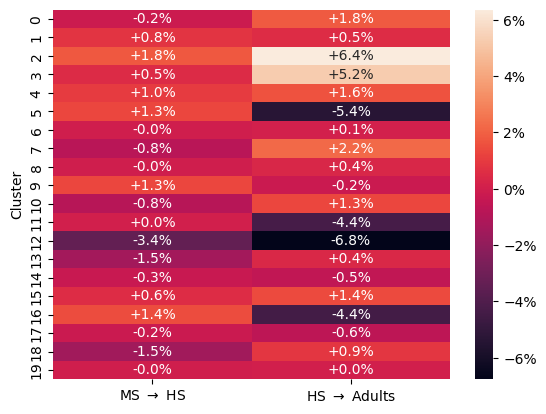

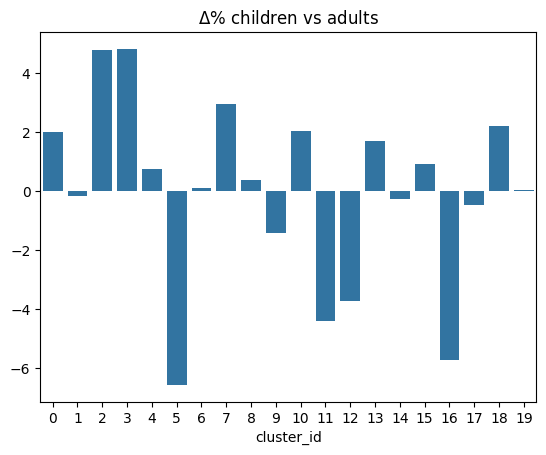

In [ ]:
# Let's inspect the percentage point differences per cluster
le_counts_grouped_normalized = le_counts_grouped.div(le_counts_grouped.sum(axis=0))

differences = pd.DataFrame(
    [
        le_counts_grouped_normalized["HS"] - le_counts_grouped_normalized["MS"],
        le_counts_grouped_normalized["Adults"] - le_counts_grouped_normalized["MS"],
    ],
    index=["MS->HS", "HS->Adults"]
).T
ax = sns.heatmap(differences, annot=True, fmt="+.1%")
# plt.title("$\Delta\%$ Clusters in LEs of age groups")
plt.ylabel("Cluster")
plt.xticks(ticks=[0.5, 1.5], labels=[r"MS $\rightarrow$ HS", r"HS $\rightarrow$ Adults"])

# Reflect percentages in the colorbar instead of fractions
colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

plt.show()
sns.barplot((le_counts_grouped_normalized["Adults"] - le_counts_grouped_normalized["Children"]) * 100)
plt.title("$\Delta\%$ children vs adults")
plt.show()

\begin{tabular}{lrrrrrr}
\toprule
cluster_id & 2 & 3 & 5 & 11 & 12 & 16 \\
\midrule
amt_intro & 0.773955 & 0.841442 & 1.121426 & 1.369244 & 0.391269 & 0.420605 \\
pos_avg_intro & 0.060422 & 0.101834 & 0.091735 & 0.087885 & 0.012272 & 0.002375 \\
pos_std_intro & 0.060462 & 0.090580 & 0.099893 & 0.099826 & 0.000000 & 0.000000 \\
amt_verse & 2.101325 & 2.012552 & 2.708680 & 2.395492 & 0.513367 & 1.561919 \\
pos_avg_verse & 1.946346 & 2.026368 & 2.247682 & 2.022423 & 0.218559 & 1.048501 \\
pos_std_verse & 2.305258 & 2.358551 & 2.179485 & 1.879798 & 0.051577 & 1.066418 \\
amt_pre_chorus & 3.045803 & 1.382953 & 0.003489 & 0.007440 & 0.006083 & 0.001439 \\
pos_avg_pre_chorus & 2.912418 & 1.496410 & 0.004505 & 0.008125 & 0.003665 & 0.001517 \\
pos_std_pre_chorus & 2.874803 & 1.566655 & 0.002947 & 0.004949 & 0.000799 & 0.001276 \\
amt_chorus & 1.786392 & 1.917443 & 0.023023 & 0.024244 & 0.110349 & 0.017767 \\
pos_avg_chorus & 2.150551 & 2.254561 & 0.041873 & 0.050926 & 0.073767 & 0.023115 \\
po

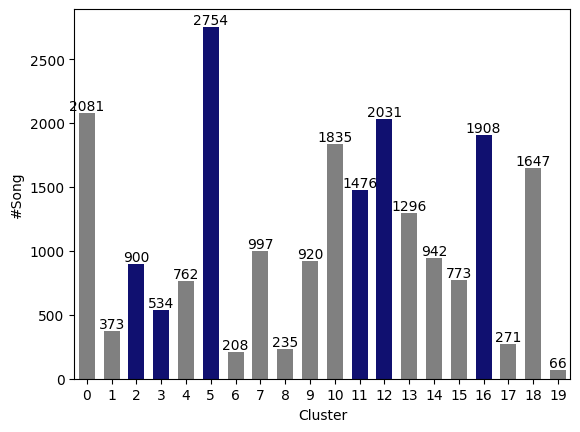

In [14]:
interesting_clusters = [2,3,5,11,12,16]
df_interesting_clusters = cluster.loc[interesting_clusters].T
print(df_interesting_clusters.to_latex())
#-------------------------------------------------------------------------------
highlight_color = 'navy'
normal_color = 'grey'

colors = [highlight_color if cluster_id in interesting_clusters else normal_color for cluster_id in cluster.index]
ax = sns.barplot(songs_per_cluster,x="cluster_id",y="song_id", hue="cluster_id", legend=False, palette=colors, width=0.8, gap=0.2)

conn,cursor = create_connection("genius_db")
cursor.execute("select cluster_id, count(distinct(artist_name)) as num_artists from song s join song_cluster sc using(song_id) group by cluster_id")
artists_per_cluster = pd.DataFrame(cursor.fetchall(), columns=["cluster_id", "#artist"]).set_index("cluster_id")
conn.close()
# sns.barplot(artists_per_cluster, x='cluster_id', y='#artist', ax=ax)

# Show label per bar 
# https://www.geeksforgeeks.org/how-to-show-values-on-seaborn-barplot/
for cont in ax.containers:
    ax.bar_label(cont)


plt.xlabel("Cluster")
plt.ylabel("#Song")
# plt.title("Distribution of songs per cluster")
plt.show()

<Figure size 1600x1600 with 0 Axes>

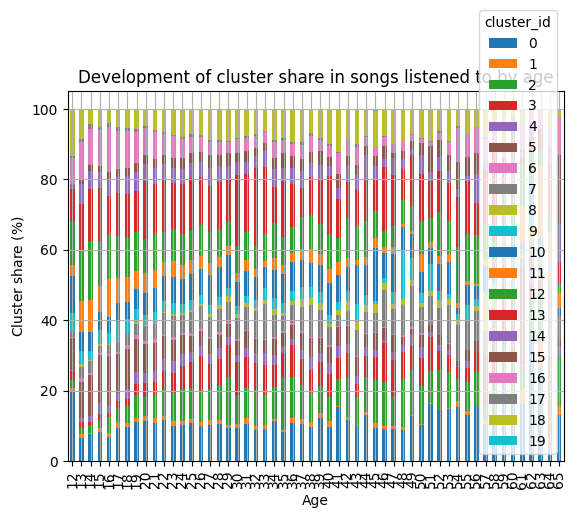

In [15]:
shown_clusters=range(20) # Show all clusters
# shown_clusters = [1,3,5,7]

shown_ages = range(12, 66) # Show all ages
# shown_ages = range(12, 18)

fig = plt.figure(figsize=(16,16))

pt_normalized = pt.div(pt.sum(axis=1), axis=0)
(pt_normalized * 100).loc[shown_ages][shown_clusters].plot.bar(
    stacked=True,
    title="Development of cluster share in songs listened to by age",
    xlabel="Age",
    ylabel="Cluster share ($\%$)",
)
plt.grid()
plt.show()

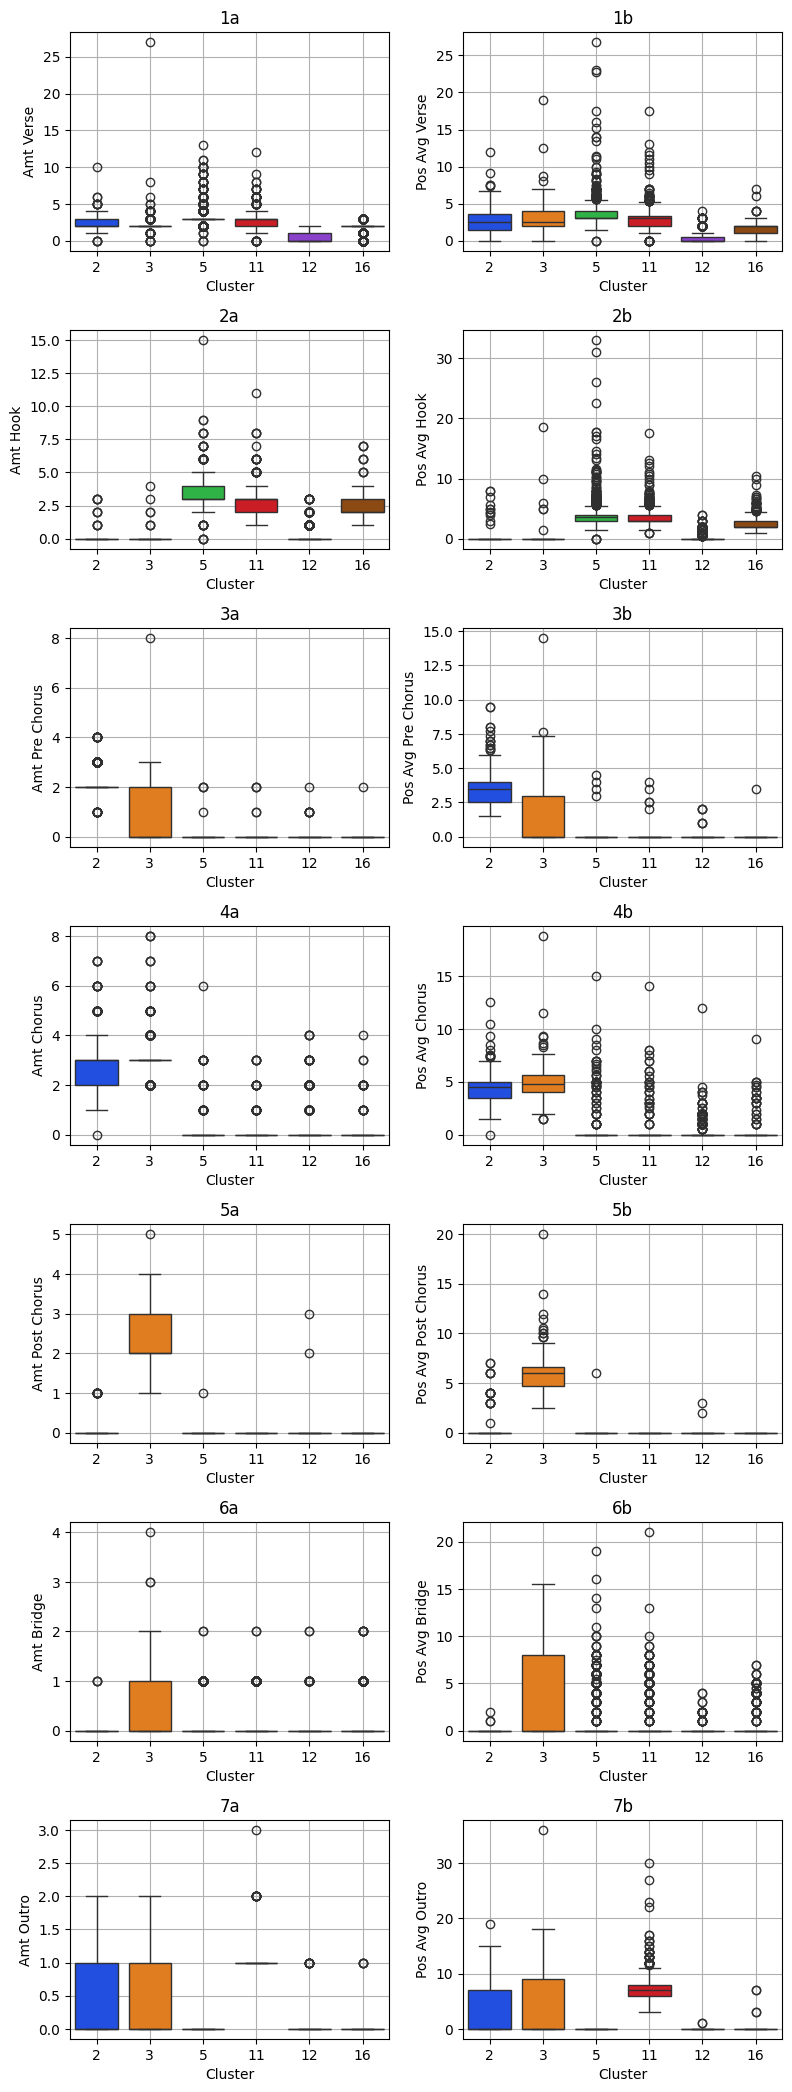

In [26]:
# Get all fingerprints for the songs with the interesting clusters.

conn, cursor = create_connection("genius_db")
cursor.execute(
    f"""
select sf.*, sc.cluster_id
from song_fingerprint sf join song_cluster sc using(song_id)
where cluster_id in ({', '.join(['%s' for _ in interesting_clusters])})
""",
    interesting_clusters,
)
cols = ["song_id"] + columns[1:] + ["cluster_id"]
fingerprints = pd.DataFrame(cursor.fetchall(), columns=cols).set_index("song_id")
conn.close()

def ax_title_generator(idx, main_axis, cols, rows):
    """
     Generates titles such as '1a', and '1b', for row/column (main_axis='row') or column/row (main_axis='col')
     Can only support up to 52 columns for suffixes [a-zA-Z].
    """
    assert main_axis in ['col', 'row'], "main_axis must be either 'col' or 'row'"
    suffixes = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
    row_idx = idx // rows
    col_idx = idx % rows
    num = row_idx + 1 if main_axis == 'row' else col_idx + 1
    suffix = suffixes[row_idx] if main_axis == 'col' else suffixes[col_idx]
    return f"{num}{suffix}" 


# Create plots for features
max_cols = 2
direction = 'col' # row = fill rows first; col = fill columns first
inch_per_column, inch_per_row = 4, 3
palette = sns.color_palette("bright")[: len(fingerprints.cluster_id.unique())]
display_title = False
display_subplot_titles = True
subplot_title_generator = ax_title_generator
interested_sections = [
    "verse",
    "hook", 
    "pre_chorus", 
    "chorus",
    "post_chorus",
    "bridge",
    "outro"
]

plots = {
    "Section feature descriptors": ["amt", "pos_avg"],
    # "Section amount" : ["amt"], 
    # "Section postition": ["pos_avg"],
}

assert direction in ['row', 'col'], "Pick row or col direction"
for title, features in plots.items():
    considered_colums = [f"{feature}_{section}" for feature in features for section in interested_sections]
    amt_considered_columns = len(considered_colums)
    ncols = min(amt_considered_columns, max_cols)
    nrows = int(np.ceil(amt_considered_columns / ncols))
    figsize = (inch_per_column * ncols, inch_per_row * nrows)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    # MAP AXES TO THE CORRECT ORDER 
    if nrows > 1:
        axes = axes.flatten() if direction == 'row' else axes.T.flatten()
    used_axes = []
    for i, (ax, feature) in enumerate(zip(axes, considered_colums)):
        sns.boxplot(
            fingerprints,
            x="cluster_id",
            hue="cluster_id",
            palette=palette,
            y=feature,
            ax=ax,
            legend=False,
        )
        ax.set_xlabel("Cluster")
        ax.set_ylabel(" ".join(map(str.capitalize, feature.split("_"))))
        ax.grid()
        used_axes.append(ax)
        if display_subplot_titles:
            ax.set_title(subplot_title_generator(i, direction, ncols, nrows))
            # ax.set_title(i)
    # Hide all unused axes 
    for ax in [ax for ax in axes if ax not in used_axes]:
        ax.set_visible(False)
    if display_title:
        fig.suptitle(title)
    
    fig.tight_layout(pad=1.0)
    plt.show()

In [ ]:
# Genres per cluster
conn, cursor = create_connection("lfm2b")
cursor.execute("""
select sc.cluster_id, g.genre_name as genre
from track t 
join lfm2b_genius lbg using(track_id)
join song_cluster sc using(song_id)
join artist_genre ag using(artist_id)
join genre g using(genre_id)
order by sc.cluster_id
""")

genres_per_cluster = pd.DataFrame(cursor.fetchall(), columns=["cluster_id", "genre"])
conn.close()
spc = pd.crosstab(genres_per_cluster.cluster_id, genres_per_cluster.genre)


genre
alternative        9683
blues               671
classical            60
country             227
easy listening      282
electronic         7295
folk               1321
heavy metal         743
jazz               1455
new age             212
pop               11157
punk               2281
rap               14786
reggae              645
rnb                8446
rock               7470
spoken word         182
vocal               276
world               967
dtype: int64

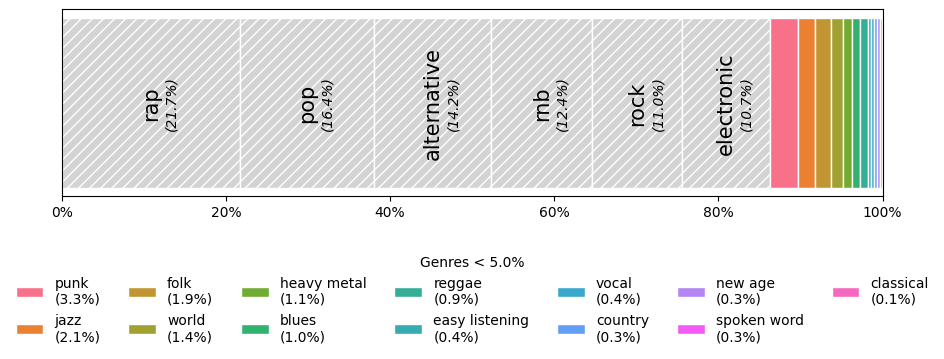

In [228]:
spc_percentages = (spc.sum().sort_values(ascending=False)/spc.sum().sum())

cumulative = spc_percentages.cumsum()
# cumulative.plot.bar(stacked=True)
# plt.title("Cumulative share of genres of the artists in the matched songs")
# plt.grid()
# plt.xticks(range(len(cumulative.index)), list(cumulative.index), rotation=90)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
# plt.show()

# Plot
threshold = 0.05
fig, ax = plt.subplots(figsize=(10, 4))
colors = sns.color_palette("husl", n_colors=spc_percentages[spc_percentages < threshold].count())
legend_handles = []
legend_labels = []
left = 0
col_idx = 0
for genre, value in zip(spc_percentages.index, spc_percentages.values):
    if value < threshold:
        color = colors[col_idx]
        col_idx += 1
        hatch = None
    else:
        color = 'lightgrey'
        hatch = '///'
    bar = ax.barh(0, value, left=left, label=genre, color=color, edgecolor='white', hatch=hatch)
    
    if value > threshold:
        ax.text(left + value / 2, 0, genre, va='center', ha='center', fontsize=15, color='black', rotation=90)
        ax.text(left + value / 2 + 0.025, 0, f"({value:.1%})", va='center', ha='center', fontsize=10, color='black', rotation=90, fontstyle='italic')
    else:
        legend_handles.append(bar[0])
        legend_labels.append(f"{genre}\n({value:.1%})")
    left += value
if legend_handles:
    ax.legend(
        handles=legend_handles,
        labels=legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.25),  # position below the plot
        ncol=7,
        frameon=False,
        title=f"Genres < {threshold:.1%}",
        fontsize=10
    )

# Clean up and display
ax.set_xlim(0, 1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_yticks([])
# ax.set_title('Genre Distribution - One Horizontal Stacked Bar')
plt.tight_layout()
plt.show()

In [74]:
percentile = .75

spc_percentages = spc.div(spc.sum(axis=1), axis=0)
cluster_top_x_percentile_genres = []
for i, row in spc_percentages.iterrows():
    sorted_vals = row.sort_values(ascending=False)
    perc = 0 
    genres = []
    for genre, percentage in sorted_vals.items():
        perc += percentage
        genres.append(genre)
        if perc >= percentile:
            cluster_top_x_percentile_genres.append((i, genres))
            break

print(f"{percentile*100:.0f}th percentile of genres per cluster")
for cluster, genres in cluster_top_x_percentile_genres:
    print(f"Cluster {cluster} : ({len(genres)}) {genres}")
    


75th percentile of genres per cluster
Cluster 0 : (6) ['rap', 'pop', 'alternative', 'rock', 'electronic', 'rnb']
Cluster 1 : (6) ['pop', 'alternative', 'rock', 'rnb', 'electronic', 'rap']
Cluster 2 : (6) ['pop', 'alternative', 'electronic', 'rap', 'rnb', 'rock']
Cluster 3 : (6) ['electronic', 'pop', 'alternative', 'rnb', 'rock', 'rap']
Cluster 4 : (5) ['rap', 'pop', 'rnb', 'alternative', 'rock']
Cluster 5 : (5) ['rap', 'pop', 'rnb', 'alternative', 'rock']
Cluster 6 : (4) ['rap', 'pop', 'rnb', 'electronic']
Cluster 7 : (6) ['pop', 'alternative', 'rock', 'electronic', 'rap', 'rnb']
Cluster 8 : (4) ['alternative', 'rock', 'pop', 'punk']
Cluster 9 : (5) ['rap', 'alternative', 'pop', 'rock', 'rnb']
Cluster 10 : (5) ['rap', 'pop', 'rnb', 'alternative', 'rock']
Cluster 11 : (5) ['rap', 'pop', 'rnb', 'alternative', 'rock']
Cluster 12 : (5) ['rap', 'pop', 'alternative', 'electronic', 'rnb']
Cluster 13 : (6) ['alternative', 'electronic', 'pop', 'rock', 'rnb', 'rap']
Cluster 14 : (5) ['rap', 'pop

In [78]:
sections = ["hook", "pre_chorus", "chorus", "post_chorus"]
combinations = []
for r in range(1, len(sections) + 1):
    combinations.extend(itertools.combinations(sections, r))

combo_queries = [
    base.format(
        " and ".join(
            f"sf.amt_{section} > 0" + 
                " and ".join(f"sf.amt_{other} = 0" for other in sections if other not in combination)
            for section in combination)
    ) +
    " as " + "_".join(combination)
    for combination in combinations
]

queries = []
base = "(select count(song_id) from lfm2b_genius join song_fingerprint sf using(song_id) where {})"
for section_combi in combinations:
    excluded_sections = [s for s in sections if s not in section_combi]
    included_where = [f"sf.amt_{section} > 0" for section in section_combi]
    excluded_where = [f"sf.amt_{section} = 0" for section in excluded_sections]
    where_clause = " and ".join(included_where + excluded_where)
    queries.append( base.format(where_clause) + f' as {"_".join(section_combi)}')
query = 'select' + ', '.join(queries)

print(query)
conn,cursor = create_connection("genius_db")
cursor.execute(query)
res = cursor.fetchall()[0]
colnames = [desc[0] for desc in cursor.description]
conn.close()

select(select count(song_id) from lfm2b_genius join song_fingerprint sf using(song_id) where sf.amt_hook > 0 and sf.amt_pre_chorus = 0 and sf.amt_chorus = 0 and sf.amt_post_chorus = 0) as hook, (select count(song_id) from lfm2b_genius join song_fingerprint sf using(song_id) where sf.amt_pre_chorus > 0 and sf.amt_hook = 0 and sf.amt_chorus = 0 and sf.amt_post_chorus = 0) as pre_chorus, (select count(song_id) from lfm2b_genius join song_fingerprint sf using(song_id) where sf.amt_chorus > 0 and sf.amt_hook = 0 and sf.amt_pre_chorus = 0 and sf.amt_post_chorus = 0) as chorus, (select count(song_id) from lfm2b_genius join song_fingerprint sf using(song_id) where sf.amt_post_chorus > 0 and sf.amt_hook = 0 and sf.amt_pre_chorus = 0 and sf.amt_chorus = 0) as post_chorus, (select count(song_id) from lfm2b_genius join song_fingerprint sf using(song_id) where sf.amt_hook > 0 and sf.amt_pre_chorus > 0 and sf.amt_chorus = 0 and sf.amt_post_chorus = 0) as hook_pre_chorus, (select count(song_id) from 

c:\Users\sanba\Documents\TU\CSE\Jaar 3\Q4\codebase\.venv\Lib\site-packages\upsetplot\data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
c:\Users\sanba\Documents\TU\CSE\Jaar 3\Q4\codebase\.venv\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original o

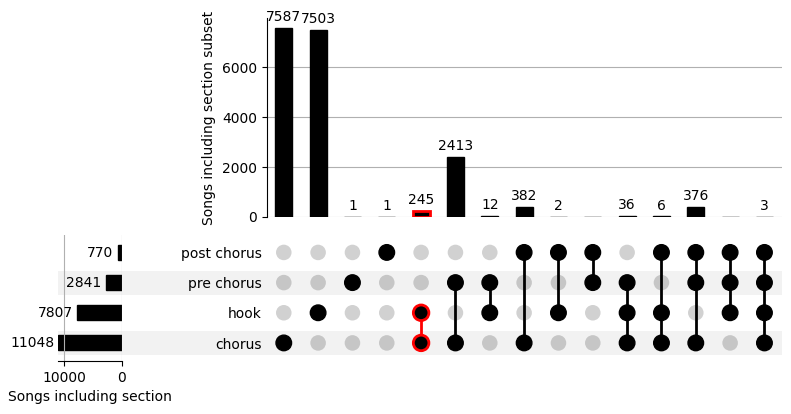

In [ ]:
def section_in_column_name(section, column_name) -> tuple[bool, str]:
    replaced = column_name.replace(section, '')
    was_replaced = replaced != column_name
    return was_replaced, replaced if was_replaced else column_name

rows = []
for column in colnames:
    # Figure out which columns are used
    column_name = column
    section_memberships = []
    for section in sorted(sections, key=len, reverse=True):
        is_member, column_name = section_in_column_name(section, column_name)
        if is_member:
            section_memberships.append(section.replace('_', ' '))
    rows.append(section_memberships)

upset_data = upsetplot.from_memberships(rows, data=res)
upset = upsetplot.UpSet(upset_data)
# upset.style_subsets(present=["chorus", "pre chorus"], absent=["hook"], edgecolor='blue', linewidth=2)
# upset.style_subsets(present=["chorus", "post chorus"], absent=["hook"], edgecolor='blue', linewidth=2)
# upset.style_subsets(present=["hook", "chorus"], absent=["pre chorus", "post chorus"], edgecolor='red', linewidth=2)
upset.style_subsets(present=["hook", "chorus"], absent=["pre chorus", "post chorus"], edgecolor='red', linewidth=2)
plot_result= upset.plot()

intersections_ax = plot_result['intersections']  
totals_ax = plot_result['totals']  
intersections_ax.set_ylabel("Songs including section subset")
totals_ax.set_xlabel("Songs including section")

# Annotate bars
for bar in intersections_ax.patches:
    height = bar.get_height()
    if height > 0:
        intersections_ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords='offset points',
                        ha='center', va='bottom')
        
for bar in totals_ax.patches:
    width = bar.get_width()
    if width > 0:
        totals_ax.annotate(f'{int(width)}',
                           xy=(width, bar.get_y() + bar.get_height() / 2),
                           xytext=(-3, 0),
                           textcoords='offset points',
                           va='center', ha='right')

plt.show()